In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/capstone/

/content/drive/My Drive/capstone


In [ ]:
import os
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = 'img'
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'test')

In [ ]:
# params
inputShape = (150, 150)
classes = 4
class_mode = 'binary' if classes < 3 else 'sparse'

# Train data and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator =  train_datagen.flow_from_directory(
    train_dir,
    target_size=inputShape,
    batch_size=64,
    color_mode='rgb',
    class_mode=class_mode)

# Validation data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator =  validation_datagen.flow_from_directory(
    validation_dir,
    target_size=inputShape,
    batch_size=16,
    color_mode='rgb',
    class_mode=class_mode)

Found 491 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


# Inception v3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = 'imagenet')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
x = tf.keras.layers.Flatten()(last_layer.output)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(classes, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=2)

Epoch 1/30
8/8 - 11s - loss: 1.2778 - accuracy: 0.4297 - val_loss: 1.1936 - val_accuracy: 0.4297 - 11s/epoch - 1s/step
Epoch 2/30
8/8 - 8s - loss: 1.0603 - accuracy: 0.5458 - val_loss: 1.0925 - val_accuracy: 0.4922 - 8s/epoch - 1s/step
Epoch 3/30
8/8 - 7s - loss: 0.9308 - accuracy: 0.6029 - val_loss: 1.0248 - val_accuracy: 0.5547 - 7s/epoch - 846ms/step
Epoch 4/30
8/8 - 8s - loss: 0.9075 - accuracy: 0.6314 - val_loss: 0.9479 - val_accuracy: 0.6094 - 8s/epoch - 1s/step
Epoch 5/30
8/8 - 7s - loss: 0.8505 - accuracy: 0.6599 - val_loss: 0.8759 - val_accuracy: 0.6328 - 7s/epoch - 880ms/step
Epoch 6/30
8/8 - 8s - loss: 0.8276 - accuracy: 0.6823 - val_loss: 0.8210 - val_accuracy: 0.7578 - 8s/epoch - 977ms/step
Epoch 7/30
8/8 - 7s - loss: 0.8095 - accuracy: 0.6925 - val_loss: 0.8317 - val_accuracy: 0.7031 - 7s/epoch - 930ms/step
Epoch 8/30
8/8 - 7s - loss: 0.7333 - accuracy: 0.7271 - val_loss: 0.7911 - val_accuracy: 0.7500 - 7s/epoch - 860ms/step
Epoch 9/30
8/8 - 7s - loss: 0.7611 - accuracy: 

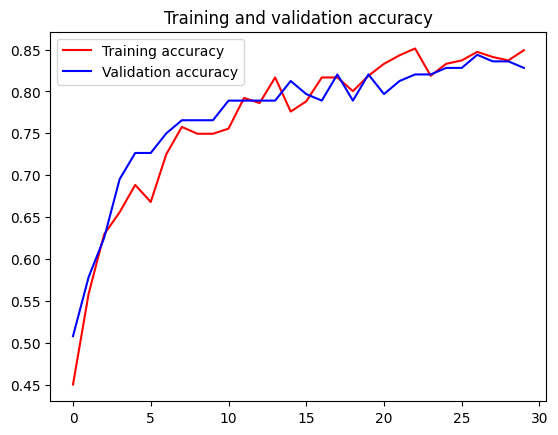

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

In [ ]:
# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

9253216